## RGB Video data

In [58]:
from skvideo.io import vread

videodata = vread("/Users/qy/Desktop/sense_making/data/RGB/a1_s3_t2_color.avi")
print(videodata.shape)
print(videodata[0,...].shape)

(39, 480, 640, 3)
(480, 640, 3)


In [2]:
videodata = vread("/Users/qy/Desktop/sense_making/data/RGB/a1_s8_t1_color.avi")
print(videodata.shape)

(60, 480, 640, 3)


In [15]:
n = 80
step = int((n - 1) / 10)
print(step)

7


## Synchronized Depth and Skeleton data
They have the same number of frames

In [1]:
from scipy.io import loadmat

filename = 'Depth/a1_s8_t1_depth.mat'
mat = loadmat(filename)
mat['d_depth'].shape

(240, 320, 76)

In [2]:
filename = 'Skeleton/a1_s8_t1_skeleton.mat'
mat = loadmat(filename)
mat['d_skel'].shape

(20, 3, 76)

In [3]:
filename = 'Depth/a1_s3_t2_depth.mat'
mat = loadmat(filename)
print(mat['d_depth'].shape)

filename = 'Skeleton/a1_s3_t2_skeleton.mat'
mat = loadmat(filename)
print(mat['d_skel'].shape)

(240, 320, 52)
(20, 3, 52)


In [9]:
filename = 'Depth/a4_s5_t4_depth.mat'
mat = loadmat(filename)
print(mat['d_depth'][:,40:280,:].shape)
print(mat['d_depth'].max())
print(mat['d_depth'].min())

(240, 240, 64)
3201
0


### Model
reference: http://media-lab.ccny.cuny.edu/wordpress/Publications/IVCJ-2016.pdf
### Resize depth data to 240 x 240 x 125

In [20]:
# resize a single file

filename = '/Users/qy/Desktop/sense_making/data/' + f'Depth/a{action}_s{subject}_t{trial}_depth.mat'
data = loadmat(filename)['d_depth'][:,40:280,:]
data = np.floor((data-data.min()) / (data.max()-data.min()) * 255)
print(data.shape)
print(data[:,:,0:64].shape)

(240, 240, 64)
(240, 240, 64)


In [21]:
# Subjects 1, 2, 3, 5, 6, 7 go into training data (75%)
# Subjects 4, 8 go into test data (25%)

import numpy as np
from keras.preprocessing import sequence
from cv2 import resize

X_train = []
Y_train = []
X_test = []
Y_test = []

# for action in range(1, 28):
for action in range(1, 3):    
    # print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = '/Users/qy/Desktop/sense_making/data/' + f'Depth/a{action}_s{subject}_t{trial}_depth.mat'
            try:
                data = loadmat(filename)['d_depth'][:,40:280,:]
                data = np.floor((data-data.min()) / (data.max()-data.min()) * 255)
                # resize                
                data_stack = np.zeros((240, 240, 125))
                n1 = data_stack.shape[2] - data.shape[2]
                data_stack[:,:,n1:125] = data 
                
            except:
                continue
            
            # if data is None: continue
            # data = np.swapaxes(data, 0, 1)
            # data = sequence.pad_sequences(data, maxlen=125)
            if subject in [1, 2 ,3, 5, 6, 7] :
                X_train.append(data_stack)
                Y_train.append(action-1)
            else:
                X_test.append(data_stack)
                Y_test.append(action-1)
                
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (48, 240, 240, 125)
Y_train.shape: (48,)
X_test.shape: (16, 240, 240, 125)
Y_test.shape: (16,)


# Optical flow from OpenCV

References:    
Implementing Lucas-Kanade Optical Flow algorithm in Python    
https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/

https://docs.opencv.org/3.3.1/d7/d8b/tutorial_py_lucas_kanade.html
    

https://github.com/jagracar/OpenCV-python-tests/blob/master/OpenCV-tutorials/videoAnalysis/denseOpticalFlow.py

## RGB video data

In [34]:
import numpy as np
import cv2

# Start the webcam
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture("/Users/qy/Desktop/sense_making/data/RGB/a1_s3_t2_color.avi")

# Take the first frame and convert it to gray
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Create the HSV color image
hsvImg = np.zeros_like(frame)
hsvImg[..., 1] = 255

optflow = []

# Play until the user decides to stop

for i in range(5):
# Save the previous frame data
    previousGray = gray
     
    # Get the next frame
    ret , frame = cap.read()
    # print(ret)
    if ret:
        # Convert the frame to gray scale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print(gray.shape)
        
        # Calculate the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(previousGray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        print(flow.shape)
        
        # Obtain the flow magnitude and direction angle
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        # Update the color image
        hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
        hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        rgbImg = cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)
        print(rgbImg.shape)
        optflow.append(rgbImg)
        # print(optflow)
        
        # Display the resulting frame
        # cv2.imshow('dense optical flow', np.hstack((frame, rgbImg)))
        # k = cv2.waitKey(30) & 0xff
        
        # Exit if the user press ESC
        # if k == 27:
        #    break
    else:
        break

optflow = np.array(optflow)
print(optflow.shape)

# When everything is done, release the capture and close all windows
cap.release()
# cv2.destroyAllWindows()

(480, 640)
(480, 640, 2)
(480, 640, 3)
(480, 640)
(480, 640, 2)
(480, 640, 3)
(480, 640)
(480, 640, 2)
(480, 640, 3)
(480, 640)
(480, 640, 2)
(480, 640, 3)
(480, 640)
(480, 640, 2)
(480, 640, 3)
(5, 480, 640, 3)


## Depth data

In [29]:
filename = 'Depth/a1_s8_t1_depth.mat'
mat = loadmat(filename)
nf = mat['d_depth'].shape[2]
step = int((nf - 1) / 10)
print(nf, step)

gray = mat['d_depth'][:,40:280,0]
gray = cv2.resize(gray, (64, 64))

optflow = []

for i in range(1, 11):
# Save the previous frame data
    print(i)
    previousGray = gray
     
    # Get the next frame
    data = mat['d_depth'][:,40:280,i * step]
    data = cv2.resize(data, (64, 64))

    # Convert the frame to gray scale
    gray = np.floor((data-data.min()) / (data.max()-data.min()) * 255)

    # Calculate the dense optical flow
    flow = cv2.calcOpticalFlowFarneback(previousGray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Obtain the flow magnitude and direction angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Update the color image
    Img1 = 0.5 * ang * 180 / np.pi
    Img2 = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    # rgbImg = cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)
    # print(rgbImg.shape)
    optflow.append(Img1)
    optflow.append(Img2)

optflow = np.array(optflow)
print(optflow.shape)

76 7
1
2
3
4
5
6
7
8
9
10
(20, 64, 64)


In [28]:
np.swapaxes(np.swapaxes(optflow,0,1),1,2).shape

(64, 64, 20)

## Function for Optical Flow Depth

In [39]:
def optflow_depth(mat):

    # mat = loadmat(filename)
    nf = mat['d_depth'].shape[2]
    step = int((nf - 1) / 10)
    # print(nf, step)

    gray = mat['d_depth'][:,40:280,0]
    gray = cv2.resize(gray, (64, 64))
    gray = np.floor((gray-gray.min()) / (gray.max()-gray.min()) * 255)

    optflow = []

    for i in range(1, 11):
    # Save the previous frame data
        previousGray = gray

        # Get the next frame
        data = mat['d_depth'][:,40:280,i * step]
        data = cv2.resize(data, (64, 64))

        # Convert the frame to gray scale
        gray = np.floor((data-data.min()) / (data.max()-data.min()) * 255)

        # Calculate the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(previousGray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Obtain the flow magnitude and direction angle
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Update the color image
        Img1 = 0.5 * ang * 180 / np.pi
        Img2 = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

        optflow.append(Img1)
        optflow.append(Img2)

    optflow = np.array(optflow)
    out = np.swapaxes(np.swapaxes(optflow,0,1),1,2)
    return out

## Function for Optical Flow RGB Video

In [64]:
from skvideo.io import vread

# videodata = vread("/Users/qy/Desktop/sense_making/data/RGB/a1_s3_t2_color.avi")
# print(videodata.shape)

def optflow_rgb(file):

    mat = vread(file)
    nf = mat.shape[0]
    step = int((nf - 1) / 10)
    # print(nf, step)

    frame = mat[0,:,80:560,:]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (64, 64))
    # gray = np.floor((gray-gray.min()) / (gray.max()-gray.min()) * 255)

    optflow = []

    for i in range(1, 11):
    # Save the previous frame data
        previousGray = gray

        # Get the next frame
        frame = mat[i * step,:,80:560,:]
        # Convert the frame to gray scale
        data = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(data, (64, 64))

        # gray = np.floor((data-data.min()) / (data.max()-data.min()) * 255)

        # Calculate the dense optical flow
        flow = cv2.calcOpticalFlowFarneback(previousGray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

        # Obtain the flow magnitude and direction angle
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        # Update the color image
        Img1 = 0.5 * ang * 180 / np.pi
        Img2 = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

        optflow.append(Img1)
        optflow.append(Img2)

    optflow = np.array(optflow)
    out = np.swapaxes(np.swapaxes(optflow,0,1),1,2)
    return out

In [30]:
import os
flist = os.listdir("Depth/")
flist[:5]

['a10_s1_t1_depth.mat',
 'a10_s1_t2_depth.mat',
 'a10_s1_t3_depth.mat',
 'a10_s1_t4_depth.mat',
 'a10_s2_t1_depth.mat']

In [59]:
flist = os.listdir("RGB/")
flist[:5]

['a10_s1_t1_color.avi',
 'a10_s1_t2_color.avi',
 'a10_s1_t3_color.avi',
 'a10_s1_t4_color.avi',
 'a10_s2_t1_color.avi']

In [34]:
file = 'Depth/' + 'a10_s2_t1_depth.mat'
test = optflow_depth(file)
test.shape

67 6


(64, 64, 20)

In [63]:
file = 'RGB/' + 'a10_s1_t1_color.avi'
test = optflow_rgb(file)
test.shape

(64, 64, 20)

In [35]:
len(flist)

861

In [40]:
# Subjects 1, 2, 3, 5, go into training data (50%)
# Subjects 6, 7 validation
# Subjects 4, 8 go into test data (25%)

import numpy as np
from cv2 import resize

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for action in range(1, 28):
# for action in range(1, 3):    
    print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            filename = '/Users/qy/Desktop/sense_making/data/' + f'Depth/a{action}_s{subject}_t{trial}_depth.mat'
            try:
                mat = loadmat(filename)
                data = optflow_depth(mat)
            except:
                continue

            
            # if data is None: continue
            # data = np.swapaxes(data, 0, 1)
            # data = sequence.pad_sequences(data, maxlen=125)
            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                Y_val.append(action-1)
            else:
                X_test.append(data)
                Y_test.append(action-1)
                
                
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
X_train.shape: (431, 64, 64, 20)
Y_train.shape: (431,)
X_val.shape: (215, 64, 64, 20)
Y_val.shape: (215,)
X_test.shape: (215, 64, 64, 20)
Y_test.shape: (215,)


In [46]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

print('Y_train.shape:', Y_train.shape)
print('Y_val.shape:', Y_val.shape)
print('Y_test.shape:', Y_test.shape)

Y_train.shape: (431, 27)
Y_val.shape: (215, 27)
Y_test.shape: (215, 27)


## CNN model for Depth data
Ref: https://www.researchgate.net/publication/326968465_Human_Action_Recognition_based_on_3D_Convolution_Neural_Networks_from_RGBD_Videos

In [51]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dropout, Flatten, Dense
from keras.layers.pooling import MaxPooling2D

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape = (64, 64, 20), 
                                  name = 'NormalizeInput'))

simple_cnn.add(Conv2D(64, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))

simple_cnn.add(Conv2D(128, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))

simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))

simple_cnn.add(Conv2D(256, kernel_size = (3,3), activation='relu', padding='same'))
simple_cnn.add(MaxPooling2D((2, 2) , strides = 2))

simple_cnn.add(Flatten())
simple_cnn.add(Dense(2048, activation='relu'))
simple_cnn.add(Dense(27, activation='softmax'))

simple_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                   # metrics = [dice_coef, 'acc', 'mse']
                   metrics = ['acc'])
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 64, 64, 20)        80        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        11584     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 256)         0         
__________

In [52]:
history = simple_cnn.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                   epochs=20, batch_size=128, verbose=2)

Train on 431 samples, validate on 215 samples
Epoch 1/20
 - 13s - loss: 3.9561 - acc: 0.0371 - val_loss: 3.3061 - val_acc: 0.0372
Epoch 2/20
 - 10s - loss: 3.3000 - acc: 0.0441 - val_loss: 3.2286 - val_acc: 0.1767
Epoch 3/20
 - 11s - loss: 3.1380 - acc: 0.1833 - val_loss: 2.7810 - val_acc: 0.1488
Epoch 4/20
 - 10s - loss: 2.4614 - acc: 0.2691 - val_loss: 2.4701 - val_acc: 0.2651
Epoch 5/20
 - 10s - loss: 2.1836 - acc: 0.4153 - val_loss: 2.0175 - val_acc: 0.3767
Epoch 6/20
 - 11s - loss: 1.5487 - acc: 0.5197 - val_loss: 1.7405 - val_acc: 0.4000
Epoch 7/20
 - 11s - loss: 1.0415 - acc: 0.6357 - val_loss: 1.9806 - val_acc: 0.4372
Epoch 8/20
 - 11s - loss: 1.0614 - acc: 0.6404 - val_loss: 1.8172 - val_acc: 0.4791
Epoch 9/20
 - 11s - loss: 0.8539 - acc: 0.6868 - val_loss: 1.3620 - val_acc: 0.5349
Epoch 10/20
 - 11s - loss: 0.6974 - acc: 0.7564 - val_loss: 1.4158 - val_acc: 0.5628
Epoch 11/20
 - 11s - loss: 0.5114 - acc: 0.8353 - val_loss: 1.5340 - val_acc: 0.4651
Epoch 12/20
 - 12s - loss: 0

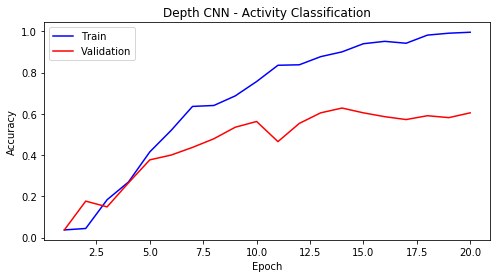

In [57]:
import matplotlib.pyplot as plt

epoch = list(range(1,21))
plt.figure(figsize=(8,4))
plt.plot(epoch, history.history['acc'], color='b')
plt.plot(epoch, history.history['val_acc'], color='r')
plt.title('Depth CNN - Activity Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Train', 'Validation'))
plt.show()

## Video data preparation and model

In [68]:
# Subjects 1, 2, 3, 5, go into training data (50%)
# Subjects 6, 7 validation
# Subjects 4, 8 go into test data (25%)

import numpy as np
from cv2 import resize

X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for action in range(1, 28):
# for action in range(1, 3):    
    print(action)
    for subject in range(1, 9):
        for trial in range(1, 5):
            # data = import_inertial_data(action, subject, trial)
            # filename = '/Users/qy/Desktop/sense_making/data/' + f'Depth/a{action}_s{subject}_t{trial}_depth.mat'
            filename = '/Users/qy/Desktop/sense_making/data/' + f'RGB/a{action}_s{subject}_t{trial}_color.avi'
            try:
                # mat = loadmat(filename)
                data = optflow_rgb(filename)
            except:
                continue

            
            # if data is None: continue
            # data = np.swapaxes(data, 0, 1)
            # data = sequence.pad_sequences(data, maxlen=125)
            if subject in [1, 2 ,3, 5] :
                X_train.append(data)
                Y_train.append(action-1)
            elif subject in [6, 7]:
                X_val.append(data)
                Y_val.append(action-1)
            else:
                X_test.append(data)
                Y_test.append(action-1)
                
                
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y_val = to_categorical(Y_val)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_val.shape:', X_val.shape)
print('Y_val.shape:', Y_val.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
X_train.shape: (431, 64, 64, 20)
Y_train.shape: (431, 27)
X_val.shape: (215, 64, 64, 20)
Y_val.shape: (215, 27)
X_test.shape: (215, 64, 64, 20)
Y_test.shape: (215, 27)


In [70]:
# video cnn model, same as depth model
history = simple_cnn.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                   epochs=20, batch_size=128, verbose=2)

Train on 431 samples, validate on 215 samples
Epoch 1/20
 - 12s - loss: 3.7213 - acc: 0.3968 - val_loss: 2.9730 - val_acc: 0.3209
Epoch 2/20
 - 10s - loss: 1.7203 - acc: 0.5128 - val_loss: 2.0187 - val_acc: 0.4326
Epoch 3/20
 - 10s - loss: 1.3082 - acc: 0.6566 - val_loss: 1.6750 - val_acc: 0.4558
Epoch 4/20
 - 11s - loss: 0.7672 - acc: 0.7657 - val_loss: 1.9595 - val_acc: 0.4512
Epoch 5/20
 - 10s - loss: 0.6096 - acc: 0.7935 - val_loss: 2.0560 - val_acc: 0.4698
Epoch 6/20
 - 12s - loss: 0.5154 - acc: 0.8306 - val_loss: 1.9425 - val_acc: 0.5535
Epoch 7/20
 - 13s - loss: 0.3143 - acc: 0.8863 - val_loss: 1.6844 - val_acc: 0.5395
Epoch 8/20
 - 12s - loss: 0.2145 - acc: 0.9281 - val_loss: 1.8605 - val_acc: 0.5256
Epoch 9/20
 - 11s - loss: 0.1350 - acc: 0.9768 - val_loss: 1.8739 - val_acc: 0.5488
Epoch 10/20
 - 12s - loss: 0.0686 - acc: 0.9907 - val_loss: 1.9859 - val_acc: 0.5488
Epoch 11/20
 - 12s - loss: 0.0364 - acc: 0.9977 - val_loss: 2.2136 - val_acc: 0.5395
Epoch 12/20
 - 11s - loss: 0

# Save and load the datasets

In [65]:
# depth optical flow data
np.savez_compressed('depth_of', X_train, Y_train, X_val, Y_val, X_test, Y_test)

In [67]:
loaded = np.load('depth_of.npz')
print(loaded.files)
print(loaded['arr_0'].shape)

['arr_0', 'arr_1', 'arr_2', 'arr_3', 'arr_4', 'arr_5']
(431, 64, 64, 20)


In [69]:
# video optical flow data
np.savez_compressed('video_of', X_train, Y_train, X_val, Y_val, X_test, Y_test)